# Temporal Difference(TD) Learning
Update action values in every time step of an episode. Advantages:
- Generally faster learning and convergence.
- Does not require a model of the environment.
- Converges to the maximum-likelihood estimate, which is more accurate in certain situations than MC. 

In [1]:
import gym
import matplotlib.pyplot as plt 
import torch
from collections import defaultdict
from pprint import pprint
from tqdm import tqdm

## Cliff Walking
Start at the bottom left of a 4x12 grid, goal is to reach the bottom right. There is a hole in between the two points. Falling into the hole leads to a -100 reward and going back to the start. Each time step causes a reward of -1.

In [2]:
env = gym.make("CliffWalking-v0")
num_states, num_actions = env.observation_space.n, env.action_space.n
num_states, num_actions

(48, 4)

In [23]:
env.reset()
env.render()        

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [24]:
new_state, reward, is_done, info = env.step(0)
new_state, reward, is_done, info

(24, -1, False, {'prob': 1.0})

In [25]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [26]:
new_state, reward, is_done, info = env.step(1)
new_state, reward, is_done, info = env.step(2)
print(reward)
env.render()

-100
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [33]:
# Optimal path
env.reset()
env.step(0)
for i in range(11):
    new_state, reward, is_done, info = env.step(1)
new_state, reward, is_done, info = env.step(2)
print(is_done)
env.render()

True
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x



### Q-Learning 
Off-policy temporal difference learning method. 

In [3]:
def gen_eps_greedy_policy(num_actions, epsilon):
    # Epsilon Greedy exploratory policy 
    def policy_function(state, Q):
        probs = torch.ones(num_actions) * epsilon / num_actions
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function


def q_learning(env, behaviour_policy, gamma, num_episodes, alpha):
    num_actions = env.action_space.n
    Q = defaultdict(lambda: torch.zeros(num_actions))
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        while not is_done:
            action = behaviour_policy(state, Q)
            next_state, reward, is_done, info = env.step(action)
            # Time step update
            del_td = reward + gamma * torch.max(Q[next_state]) - Q[state][action]   
            Q[state][action] += alpha * del_td
            state = next_state
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [4]:
gamma = 1
num_episodes = 500
alpha = 0.4
epsilon = 0.1
behaviour_policy = gen_eps_greedy_policy(env.action_space.n, epsilon)
optimal_Q, optimal_policy = q_learning(env, behaviour_policy, gamma, num_episodes, alpha)
print("\nOptimal policy: \n", optimal_policy)

100%|██████████| 500/500 [00:03<00:00, 129.57it/s]
Optimal policy: 
 {36: 0, 24: 1, 12: 1, 0: 3, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 2, 9: 1, 10: 1, 11: 2, 22: 2, 23: 2, 35: 2, 21: 2, 20: 2, 19: 1, 18: 2, 30: 1, 17: 1, 16: 2, 15: 1, 14: 1, 13: 2, 33: 1, 34: 1, 47: 0, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 31: 1, 32: 1}



In [9]:
import time

def run_episode(env, policy):
    # Visual representation of actions taking place
    is_done = False
    total_reward = 0
    state = env.reset()
    env.render()
    while not is_done:
        action = policy[state]
        time.sleep(1)
        state, reward, is_done, info = env.step(action)
        env.render()
        total_reward += reward
    time.sleep(1)
    env.close()
    print("Total reward:", total_reward)


run_episode(env, optimal_policy)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o

In [8]:
print(dir(env))

['P', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_calculate_transition_prob', '_cliff', '_limit_coordinates', 'action_space', 'close', 'isd', 'lastaction', 'metadata', 'nA', 'nS', 'np_random', 'observation_space', 'render', 'reset', 'reward_range', 's', 'seed', 'shape', 'spec', 'start_state_index', 'step', 'unwrapped']


## Windy Gridworld
Start at position 30 of a 7x10 board, finish at position 37. Extra wind force in columns 4 to 9 causes the agent to move upwards at each action in these columns (1 force at 4-6, 9 and 2 at 7-8). -1 reward at each timestep.

In [2]:
import numpy as np
import sys
from gym.envs.toy_text import discrete

UP, RIGHT, DOWN, LEFT = range(4)

In [31]:
class WindyGridWorld(discrete.DiscreteEnv):
    def __init__(self):
        self.shape = (7, 10)
        nS = self.shape[0] * self.shape[1]
        nA = 4
        winds = np.zeros(self.shape)
        winds[:, [3,4,5, 8]] = 1
        winds[:, [6, 7]] = 2
        self.goal = (3, 7)
        # Transition probability calculation from GridWorld
        P = {}
        for s in range(nS):
            position = np.unravel_index(s, self.shape)
            P[s] = {a: [] for a in range(nA)}
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)            
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)            
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)            
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
        # Starting position (3, 0)
        initial_s = np.zeros(nS)
        initial_s[np.ravel_multi_index((3,0), self.shape)] = 1.0
        super(WindyGridWorld, self).__init__(nS, nA, P, initial_s)

    def _calculate_transition_prob(self, current, move, winds):
        # Transition probability for a position landed on is 1.0, new_state calculated
        new_position = np.array(current) + np.array(move) + np.array([-1, 0]) * winds[(tuple(current))]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == self.goal
        return [(1.0, new_state, -1, is_done)]

    def _limit_coordinates(self, coord):
        for i in range(2):
            coord[i] = min(coord[i], self.shape[i] - 1)
            coord[i] = max(0, coord[i])
        return coord

    def render(self):
        outfile = sys.stdout
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            if self.s == s:
                output = " x "
            elif position == self.goal:
                output = " T "
            else:
                output = " o "
            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"
            outfile.write(output)
        outfile.write("\n")

In [41]:
env = WindyGridWorld()
env.reset()
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [45]:
print(env.step(1))
# print(env.step(1))
# print(env.step(1))
env.render()

(24, -1, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



### SARSA
An on-policy TD learning algorithm, follows the epsilon-greedy policy to update Q.

In [52]:
env = WindyGridWorld()

num_episodes = 500
episode_length = [0] * num_episodes
total_reward_episode = [0] * num_episodes

gamma = 1
alpha = 0.4
epsilon = 0.1
eps_policy = gen_eps_greedy_policy(env.action_space.n, epsilon)

In [104]:
def sarsa(env, gamma, num_episodes, alpha, eps_policy):
    num_actions = env.action_space.n
    Q = defaultdict(lambda: torch.zeros(num_actions))
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        action = eps_policy(state, Q)
        while not is_done:
            next_state, reward, is_done, info = env.step(action)
            next_action = eps_policy(next_state, Q)
            del_td = reward + gamma * Q[next_state][next_action] - Q[state][action]
            Q[state][action] += alpha * del_td
            # For plotting
            episode_length[episode] += 1
            total_reward_episode[episode] += reward
            state = next_state
            action = next_action
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [59]:
optimal_Q, optimal_policy = sarsa(env, gamma, num_episodes, alpha, eps_policy)
print("\nOptimal policy: \n", optimal_policy)


Optimal policy: 
 {30: 1, 20: 1, 10: 3, 0: 3, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 19: 2, 12: 1, 11: 1, 29: 2, 18: 0, 13: 1, 21: 1, 22: 0, 23: 1, 39: 2, 28: 1, 31: 1, 32: 1, 33: 1, 14: 1, 49: 3, 38: 1, 17: 0, 42: 2, 41: 1, 40: 2, 43: 1, 50: 2, 51: 1, 52: 1, 53: 1, 24: 1, 59: 2, 48: 3, 61: 1, 62: 1, 63: 1, 34: 1, 27: 2, 15: 1, 60: 1, 44: 1, 54: 1, 25: 1, 69: 3, 58: 3, 37: 0, 16: 1, 45: 1, 68: 0, 35: 1, 47: 2, 26: 3, 57: 0, 36: 2}


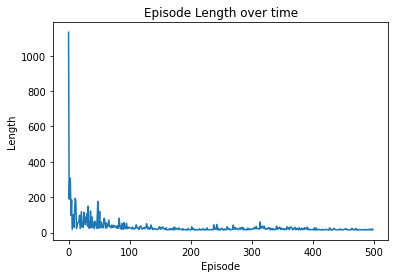

In [60]:
plt.plot(episode_length)
plt.title("Episode Length over time")
plt.xlabel("Episode")
plt.ylabel("Length")
plt.show()

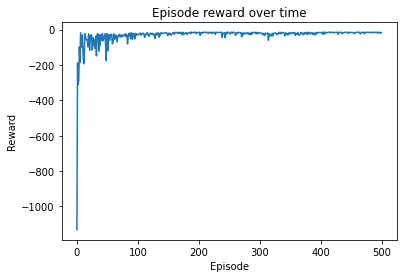

In [61]:
plt.plot(total_reward_episode)
plt.title("Episode reward over time")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## Taxi Service 
You are a taxi driver who has to pick up and drop off passengers on a 5x5 grid. There a 6 possible actions (4 movement directions, pick up and drop off), pick up, drop off and taxi positions are randomly selected. 4 possible pick up (+1 if already in taxi) and drop off positions (on the sides of the board) leading to 25x5x4 = 500 states.
Rewards:
 - -1 per time step 
 - -10 for each illegal pick up/drop off 
 - +20 for a successful drop off. 

In [65]:
env = gym.make("Taxi-v3")
num_actions, num_states = env.action_space.n, env.observation_space.n
num_actions, num_states

(6, 500)

In [78]:
print(env.reset())
env.render()

454
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [102]:
num_episodes = 1000 # 1600
episode_length = [0] * num_episodes
total_reward_episode = [0] * num_episodes

gamma = 1
alpha = 0.4
epsilon = 0.1
behaviour_policy = gen_eps_greedy_policy(env.action_space.n, epsilon)

def q_learning(env, behaviour_policy, gamma, num_episodes, alpha):
    num_actions = env.action_space.n
    Q = defaultdict(lambda: torch.zeros(num_actions))
    for episode in tqdm(range(num_episodes)):
        # if (episode + 1) % 400 == 0:
        #     alpha /= 2
        state = env.reset()
        is_done = False
        while not is_done:
            action = behaviour_policy(state, Q)
            next_state, reward, is_done, info = env.step(action)
            # Time step update
            del_td = reward + gamma * torch.max(Q[next_state]) - Q[state][action]   
            Q[state][action] += alpha * del_td
            state = next_state
            total_reward_episode[episode] += reward
            episode_length[episode] += 1
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [100]:
optimal_Q, optimal_policy = q_learning(env, behaviour_policy, gamma, num_episodes, alpha)
# print("\nOptimal policy: \n", optimal_policy)

100%|██████████| 1600/1600 [00:10<00:00, 149.05it/s]


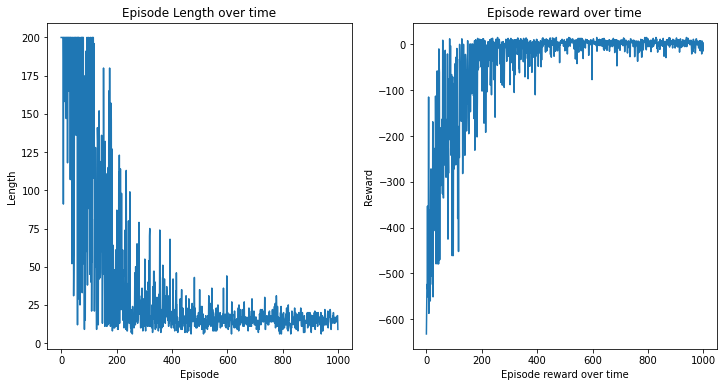

In [91]:
def plot_rate(episode_length, total_reward_episode):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(episode_length)
    ax[0].set_title("Episode Length over time")
    ax[0].set(xlabel="Episode", ylabel="Length")
    ax[1].plot(total_reward_episode)
    ax[1].set_title("Episode reward over time")
    ax[1].set(xlabel="Episode reward over time", ylabel="Reward")

    plt.show()

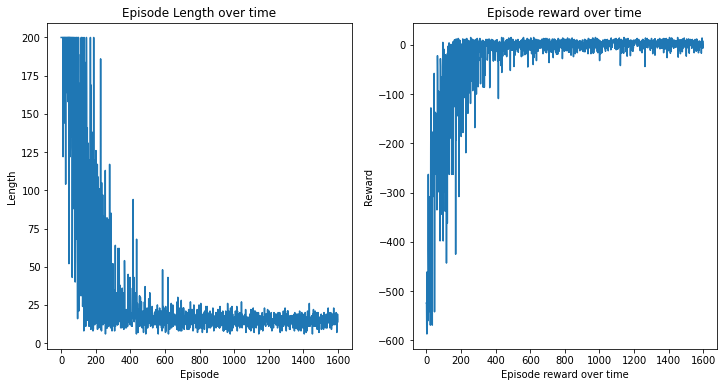

In [101]:
plot_rate(episode_length, total_reward_episode)

100%|██████████| 1000/1000 [00:08<00:00, 124.10it/s]


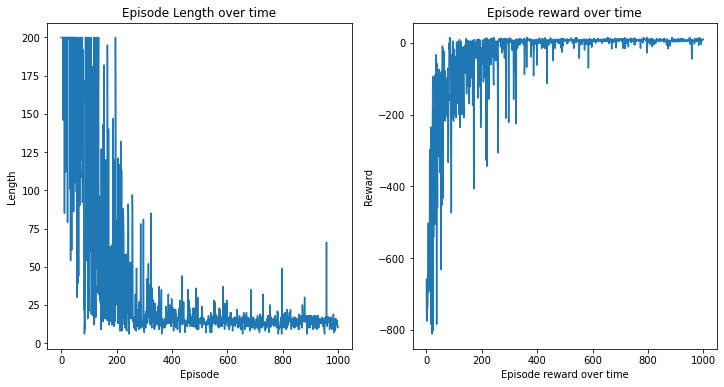

In [105]:
num_episodes = 1000 # 1600
episode_length = [0] * num_episodes
total_reward_episode = [0] * num_episodes

gamma = 1
alpha = 0.6
epsilon = 0.01        # Grid Search parameters
eps_policy = gen_eps_greedy_policy(env.action_space.n, epsilon)
optimal_Q, optimal_policy = sarsa(env, gamma, num_episodes, alpha, eps_policy)

plot_rate(episode_length, total_reward_episode)

### Double Q-Learning
Naive Q-Learning can sometimes perform poorly, as it may overestimate action values due to its greedy component. Double Q learning uses two Q functions (Q1 and Q2) and randomly updates one of them each iteration. 

However, convergence may be slower as action values can be underestimated (as they aren't updated in each iteration.)

In [126]:
def double_q_learning(env, gamma, num_episodes, alpha, eps_policy):
    num_actions, num_states = env.action_space.n, env.observation_space.n
    # Create defaultdict if number of states unknown
    # Easier to create tensors here instead of writing a way to add defaultdicts
    Q1, Q2 = torch.zeros(num_states, num_actions), torch.zeros(num_states, num_actions)
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        while not is_done:
            action = eps_policy(state, Q1 + Q2)
            next_state, reward, is_done, info = env.step(action)
            if torch.rand(1).item() < 0.5:             # update 1 randomly
                best_next_action = torch.argmax(Q1[next_state])
                del_td = reward + gamma * Q2[next_state][best_next_action] - Q1[state][action]
                Q1[state][action] += del_td * alpha
            else:
                best_next_action = torch.argmax(Q2[next_state])
                del_td = reward + gamma * Q1[next_state][best_next_action] - Q2[state][action]
                Q2[state][action] += del_td * alpha
            state = next_state
            
            episode_length[episode] += 1
            total_reward_episode[episode] += reward
    policy = {}
    Q = Q1 + Q2            # Combine both policies into 1
    for state in range(num_states):
        policy[state] = torch.argmax(Q[state]).item()
    return Q, policy

In [127]:
num_episodes = 3000 # 1600
episode_length = [0] * num_episodes
total_reward_episode = [0] * num_episodes

gamma = 1
alpha = 0.4
epsilon = 0.1       
eps_policy = gen_eps_greedy_policy(env.action_space.n, epsilon)

optimal_Q, optimal_policy = double_q_learning(env, gamma, num_episodes, alpha, eps_policy)

100%|██████████| 3000/3000 [00:24<00:00, 122.72it/s]


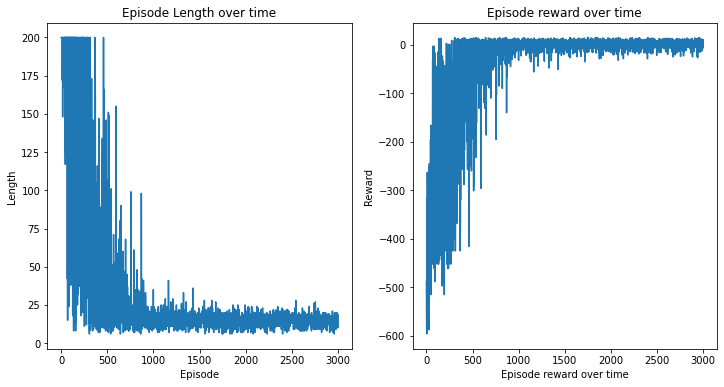

In [128]:
plot_rate(episode_length, total_reward_episode)